In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(ComplexHeatmap))

In [2]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Neuronal/code"

In [6]:
coembed <- readRDS("../data/coembed/coembed.cleaning.Rds")
coembed

An object of class Seurat 
140055 features across 1425 samples within 3 assays 
Active assay: RNA (29126 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 5 dimensional reductions calculated: pca, umap, harmony, umap_harmony, umap_harmony_v2

In [7]:
## add annotation
new.cluster.ids <- c("0" = "Neuronal",
               "1" = "Trash",
               "2" = "Purkinje_fibers")

Idents(coembed) <- "RNA_snn_res.0.1"

coembed <- RenameIdents(coembed, new.cluster.ids)
coembed$annotation <- Idents(coembed)

In [9]:
coembed <- subset(coembed, annotation != "Trash")
coembed

An object of class Seurat 
140055 features across 1170 samples within 3 assays 
Active assay: RNA (29126 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 5 dimensional reductions calculated: pca, umap, harmony, umap_harmony, umap_harmony_v2

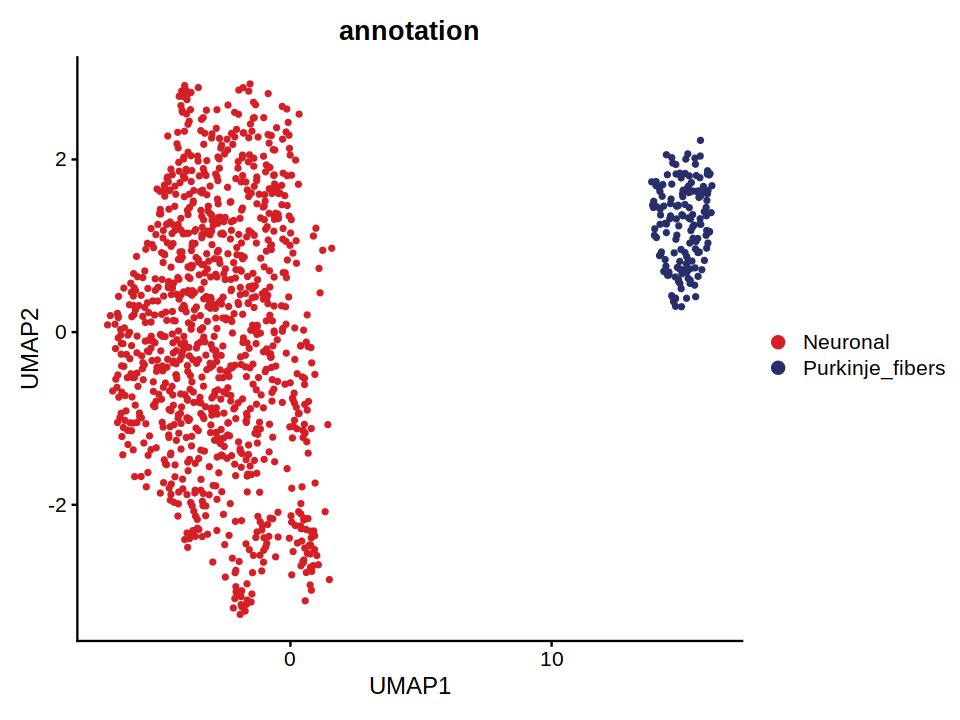

In [10]:
cols.states <- ArchR::paletteDiscrete(coembed@meta.data[, "annotation"])

p <- DimPlot(coembed, group.by = "annotation", label = FALSE,
             reduction = "umap_harmony_v2", shuffle = TRUE) +
    scale_color_manual(values = cols.states) +
    xlab("UMAP1") + ylab("UMAP2")

options(repr.plot.height = 6, repr.plot.width = 8)

p

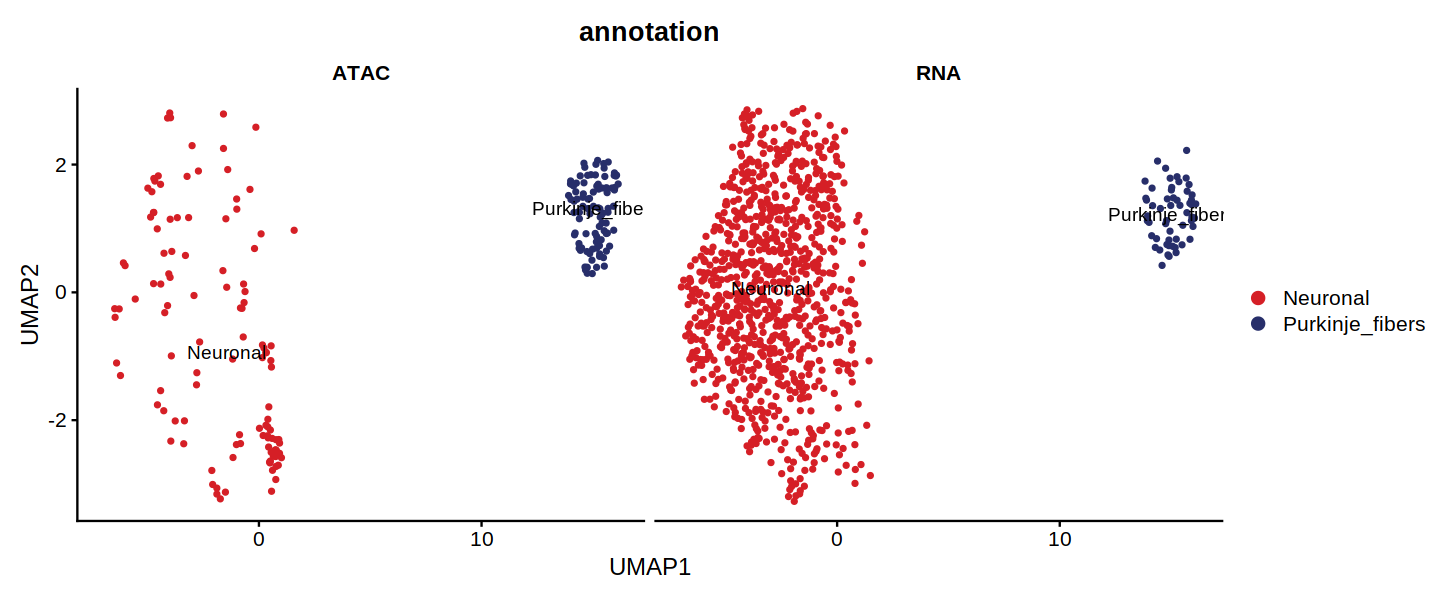

In [11]:
options(repr.plot.width = 12, repr.plot.height = 5)

p <- DimPlot(coembed, group.by = "annotation", label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE, split.by = "tech", cols=cols.states) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [12]:
meta.data <- as.data.frame(coembed@meta.data)

`summarise()` has grouped output by 'patient'. You can override using the `.groups` argument.



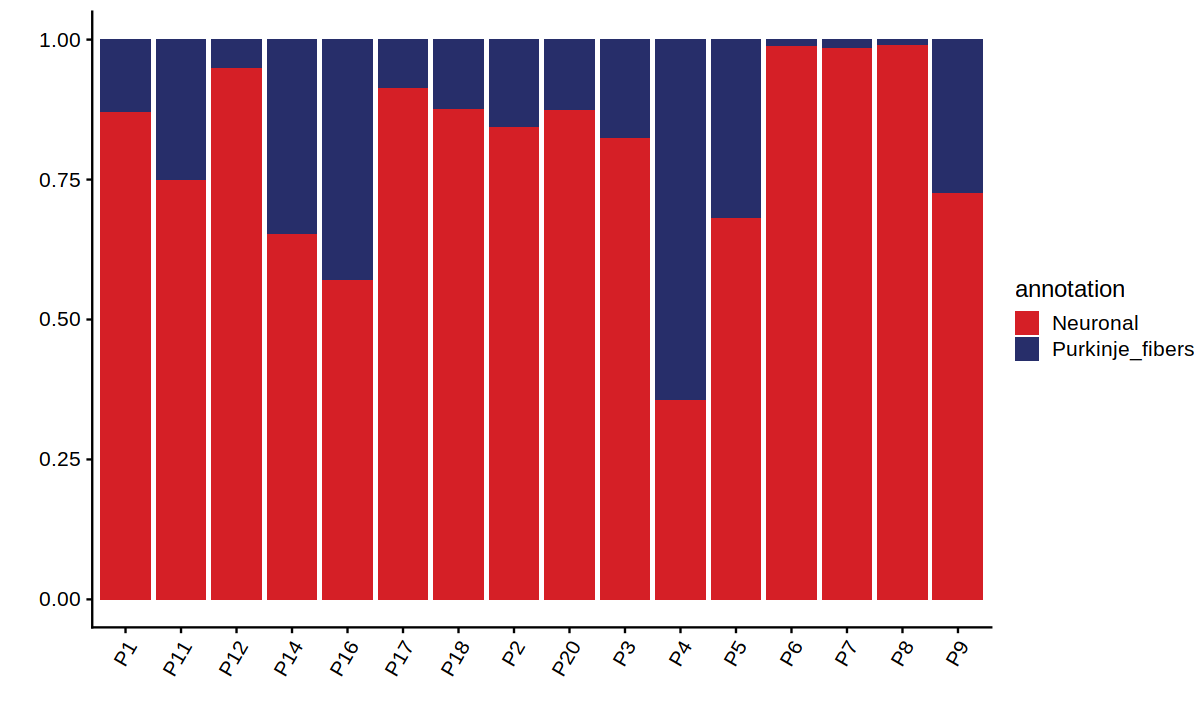

In [13]:
df_plot <-  meta.data %>%
    group_by(patient, annotation) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient, cell_proportion, fill=annotation)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.states) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.



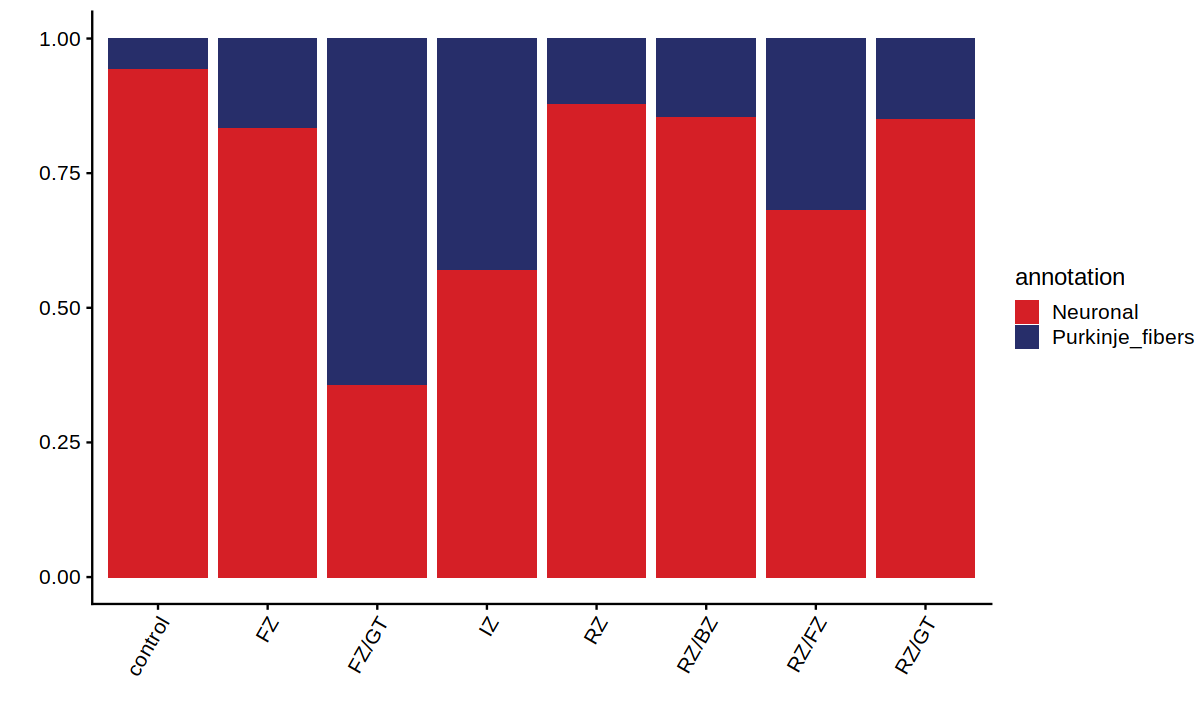

In [14]:
df_plot <- meta.data %>%
    group_by(region, annotation) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(region, cell_proportion, fill=annotation)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.states) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'patient_group'. You can override using the `.groups` argument.



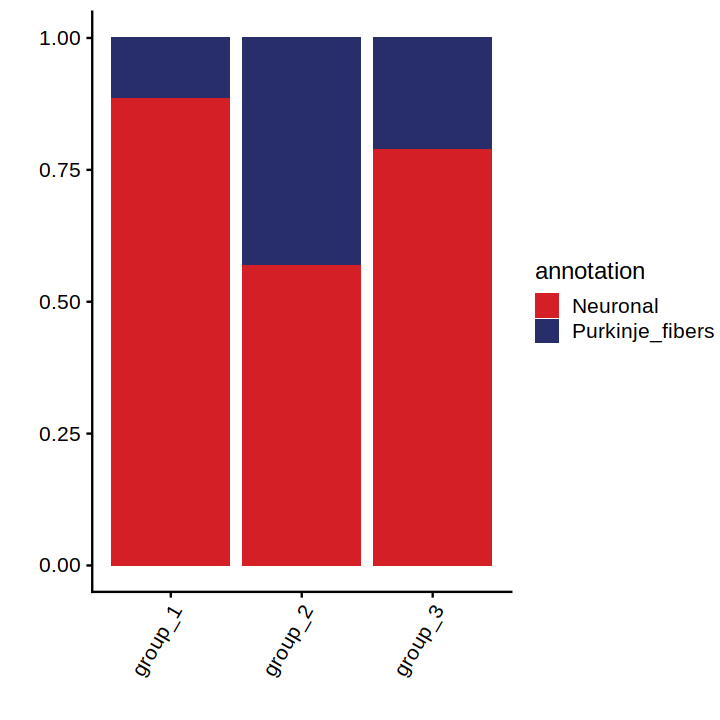

In [15]:
df_plot <- meta.data %>%
    group_by(patient_group, annotation) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient_group, cell_proportion, fill=annotation)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.states) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 6, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'patient_region_id'. You can override using the `.groups` argument.



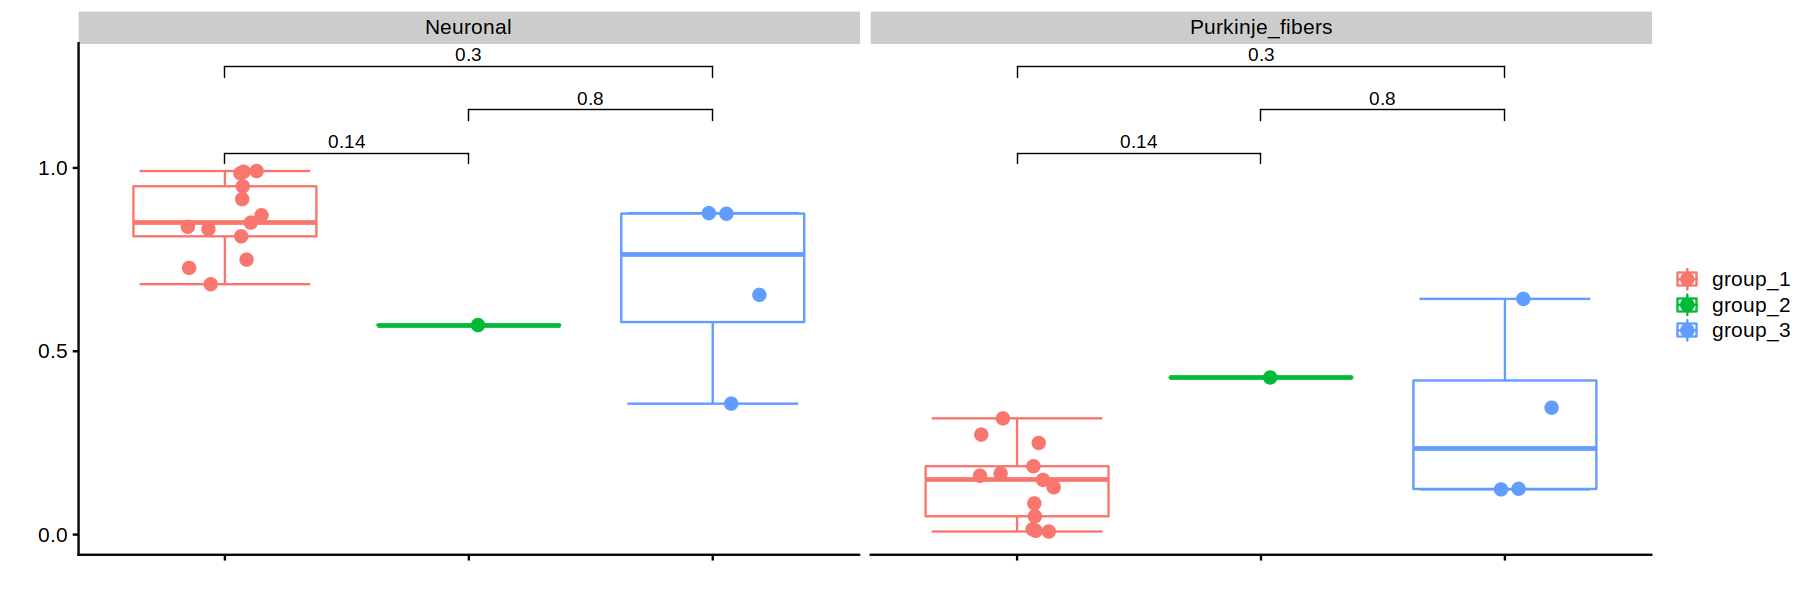

In [16]:
df_plot <- meta.data %>% 
            group_by(patient_region_id, annotation) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts))

df_anno <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., select = c("patient_region_id", "patient_group")) %>%
    unique()

df_plot <- merge.data.frame(df_plot, df_anno)
    
    p <- ggplot(data = df_plot, aes(x = patient_group, y = proportion)) +
    geom_boxplot2(aes(color = patient_group)) +
    geom_point(aes(color = patient_group), position = position_jitterdodge(), size = 3) +
    facet_wrap(~annotation, nrow = 1) +
    stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                         c("group_2", "group_3"),
                                         c("group_1", "group_3")),
                   method = "wilcox.test") +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_blank(),
         legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5)

print(p)

In [ ]:
Idents(coembed) <- "annotation"

In [ ]:
all.markers <- FindAllMarkers(coembed, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
    
df <- all.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

p <- DotPlot(coembed, features = unique(df$gene)) + RotatedAxis()
    
options(repr.plot.height = 5, repr.plot.width = 18)

print(p)

In [ ]:
if(!dir.exists("../data/coembed/MarkerGenesAfterAnnotation")){
    dir.create("../data/coembed/MarkerGenesAfterAnnotation")
}

In [ ]:
markerList <- split(all.markers, all.markers$cluster)
    
    for(i in 1:length(markerList)){
        markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$avg_log2FC), ]
    }
    
    WriteXLS::WriteXLS(markerList,
                   ExcelFileName = glue::glue("../data/coembed/MarkerGenesAfterAnnotation/annotation.xlsx"),
                   SheetNames = names(markerList))

saveRDS(all.markers, glue::glue("../data/coembed/MarkerGenesAfterAnnotation/annotation.rds"))

In [ ]:
saveRDS(coembed, file = "../data/coembed/coembed.annotation.Rds")

In [ ]:
sessionInfo()